# Gaussian processes

The theory discussion in this section is currently __very__ incomplete. Hopefully the implementation discussion will still be helpful however.

## A bit of background

Now that we've encountered a means for mathematically describing the similarity between data we need to develop some method to take this information and perform regression. 

Suppose every observation which we make is drawn from a normal distribution which has some mean value, and some standard deviation.

\\[ y \sim \mathcal{N}(\mu, \sigma) \\]

This means that if we have a whole set of data it will be drawn from a multivariate normal distribution: we'll have a collection of random variables. So for two data

\\[ (y_1, y_2) \sim \mathcal{N}(\vec{\mu}, \Sigma) \\]

where $\Sigma$ is the covariance matrix for the multivariate normal distribution. We can extend this continually to whatever size of data set we have.

We define $\Sigma$ as the covariance of the points $(x_1, x_2)$ where the data $(y_1, y_2)$ are observed, and we end up with a *Gaussian process prior*; for simplicity we normally take the mean to be zero (and this can be ensured by pre-processing our data).

In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

### Example: Fitting a one-dimensional function

Let's return to the fitting problem from the previous chapter, and see how a Gaussian process performs on this data.

findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.
findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans.


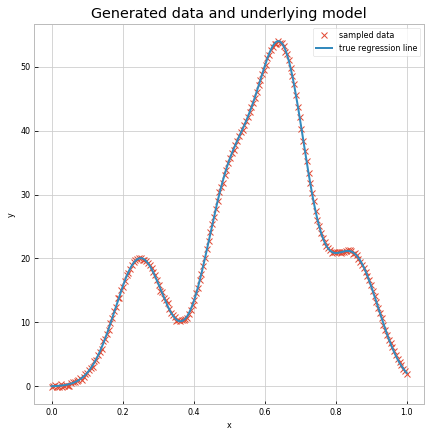

In [2]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x

def normal(x, mean, std):
    return np.exp(-(x-mean)**2/std**2)/std**2

true_regression_line = 0.3*normal(x,0.5,0.1) + 0.2*normal(x,0.25,0.1) + 0.2*normal(x,0.85,0.1) + 0.5*normal(x,0.65,0.1)
y = true_regression_line + np.random.normal(scale=.15, size=size)

data = dict(x=x, y=y)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

The `pymc3` implementation of the type of Gaussian process we need is called a "marginal likelihood" model. We need to specify our covariance function, and also a prior distribution on the noise in the signal.

In [3]:
with pm.Model() as model:
    # Specify the covariance function.
    cov_func = pm.gp.cov.ExpQuad(1, 0.1)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0, 2)
    y_ = gp.marginal_likelihood("y", X=x[::,None], y=y, noise=sigma)

/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


The slightly odd index `x[::,None]` converts `x` from a one-dimensional array to a two-dimensional one, as `pymc3` expects the data to be two dimensional.

Now that we have our model, we need to run an optimiser on it. For this model this will be very fast, since we've put most of the numbers in by hand.

In [4]:
with model:
    mp = pm.find_MAP()

/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequen

With our "trained" model we can now have a look at the fitting function and the model's predictions for regions outwith the trained parameter space.

In [5]:
x_new = np.linspace(0,2, 200)[::,None]

In [6]:
mu, var = gp.predict(x_new, point=mp, diag=True)
sd = np.sqrt(var)

/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
/home/daniel/.pyenv/versions/3.7.4/envs/teaching-stats/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice

The `gp.predict` method takes a new set of points to evaluate the mean function from the Gaussian process at, along with the variance at each of those points.

We can then plot the mean function and an error region around the mean.

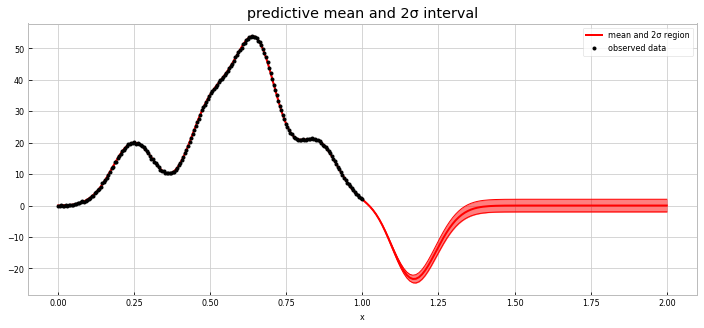

In [7]:
# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 2σ intervals
plt.plot(x_new, mu, 'r', lw=2, label="mean and 2σ region");
plt.plot(x_new, mu + 2*sd, 'r', lw=1); plt.plot(x_new, mu - 2*sd, 'r', lw=1);
plt.fill_between(x_new.flatten(), mu - 2*sd, mu + 2*sd, color="r", alpha=0.5)

# plot original data and true function
plt.plot(x, y, 'ok', ms=3, alpha=1.0, label="observed data");
#plt.plot(x, f_true, "dodgerblue", lw=3, label="true f");

plt.xlabel("x");# plt.ylim([-13,13]);
plt.title("predictive mean and 2σ interval"); plt.legend();

We can see that the GP does a very good job of regression on the data, with the error region almost impossible to see. However, outside the trained area things get less clear, and the error region expands.

We can also look at the actual functions which can be drawn from the GP. `pymc3` does this with a method called `gp.conditional`, and again we specify the locations at which we want the functions to be evaluated.

In [8]:
with model:
    f_pred = gp.conditional("f_pred", x_new)

Then we can draw the samples from the GP.

In [9]:
with model:
    pred_samples = pm.sample_ppc([mp], vars=[f_pred], samples=2000)

100%|██████████| 2000/2000 [00:30<00:00, 65.96it/s]


/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


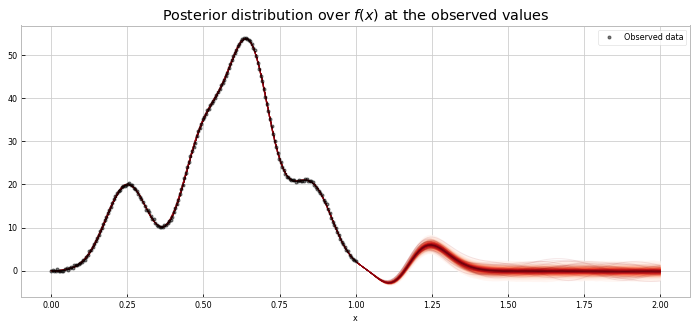

In [10]:
fig = plt.figure(figsize=(12,5))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], x_new);

plt.plot(x, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("x"); 
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

## Gaussian Process Mixtures

Up to now we've encountered Gaussian processes where the input data was one dimensional, however there are many situations where the ability to model a two dimensional (or higher) function would be valuable. 

To do this we can turn to _Gaussian process mixtures_.

Let's start by looking at a simple 2D function, 

\\[ z(x,y) = \sin(x) + \sin(y) \\]

In [30]:
x = np.linspace(-10,10, 100)
y = np.linspace(-10,10, 100)
gridpoints = np.meshgrid(x, y)
points = np.dstack(gridpoints).reshape(-1,2)
z = (np.cos(points[:,0]) + np.cos(points[:,1]))

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


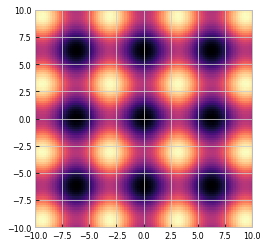

In [31]:
plt.imshow(z.reshape(100,100), extent=(-10,10,-10,10))

When observed at with this density of points, the form of the function is fairly clear, but if we reduce the number of points, so that there are just 100, rather than the 10,000 used for this plot, it's a lot harder to distinguish the form of the function.

In [56]:
data = np.vstack([points.T, z]).T
idx = np.random.randint(low=0, high=len(data), size=100)

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


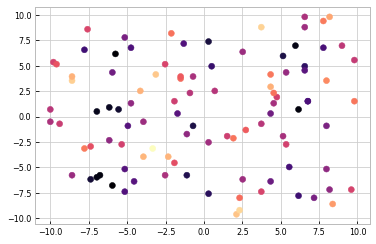

In [63]:
plt.scatter(x=data[idx,0], y=data[idx,1], c=data[idx,2])

We can try and use a Gaussian process to recover the underlying function which these points were drawn from. 

The definition of this model is similar to the one-dimensional one above, but there are three differences. First, when we define the covariance function the function's first argument. In the example above this is `1`, and here it's `2` -- this defined the dimensionality of the model, which here is 2D.

Second, is the definition of the length scale. Again, in the previous example this was hard-coded as `0.1`, and in the example below we've defined it as a variable, `ls`. That variable contains a prior distribution on the length scale, and that prior has a shape `2` (since we now have two different dimensions, with differing length scales.

Finally, the likelihood function now receives a 2d vector of X values rather than a 1D vector.

In [83]:
with pm.Model() as model:
    # Specify the covariance function.
    
    ls = pm.HalfCauchy("metric", beta=1, shape=2)
    
    cov_func = pm.gp.cov.ExpQuad(2, ls)

    # Specify the GP.  The default mean function is `Zero`.
    gp = pm.gp.Marginal(cov_func=cov_func)

    # 
    sigma = pm.Normal("sigma", 0, 0.002)
    y_ = gp.marginal_likelihood("y", X=data[idx,:2], y=data[idx,2], noise=sigma)

INFO (theano.gof.compilelock): Refreshing lock /home/daniel/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock


Because we placed a prior distribution on the length scale, the inference procedure will take a little longer, as this needs to be _learned_ by the model.

In [84]:
with model:
    mp = pm.find_MAP()

INFO (theano.gof.compilelock): Refreshing lock /home/daniel/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock
logp = -90.39, ||grad|| = 37.385: 100%|██████████| 11/11 [00:00<00:00, 82.36it/s] 


Let's draw predictions from the Gaussian process at the same points we used for the plot above, and see how the results compare.

In [85]:
mu, var = gp.predict(data[:,:2], point=mp, diag=True)
sd = np.sqrt(var)

INFO (theano.gof.compilelock): Refreshing lock /home/daniel/.theano/compiledir_Linux-4.4--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/lock_dir/lock


/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


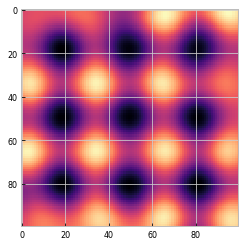

In [86]:
plt.imshow(mu.reshape(100,100))

Comparing this to both the original plot, and the plot with the 100 training points, we can see that the inference has been performed remarkably well, and the form of the function is clearly visible. We can also examine the uncertainty of the prediction across the space.

/home/daniel/.virtualenvs/aries/gp-tutorial/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ["'URW Bookman L'"] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


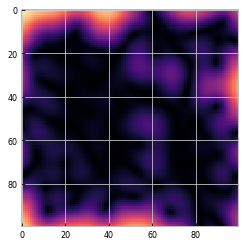

In [89]:
plt.imshow(sd.reshape(100,100), cmap="magma")

We can see that the edges have the greatest uncertainty, which is a result which squares nicely with the mean prediction, which looks poorer in those areas.